#### Importing and Preprocessing

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
import math
import joblib
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

plt.style.use("fivethirtyeight")

# Install and import TensorFlow
import subprocess
import sys
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow"])
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM

In [12]:
import json

try:
    # Try to load from your sensor JSON file
    with open('sensor_data.json', 'r') as f:
        data_list = json.load(f)
    
    df = pd.DataFrame(data_list)
    
    # Parse the date_heure column
    df['Timestamp'] = pd.to_datetime(df['date_heure'], format='%H:%M:%S %d/%m/%Y')
    
    # Use temperature or humidity as the prediction target (like PM2.5)
    # We'll predict temperature fluctuations
    df = df.sort_values('Timestamp').reset_index(drop=True)
    
    print("✓ Dataset loaded from sensor_data.json")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {df.columns.tolist()}")
    
except FileNotFoundError:
    try:
        # Try to load from CSV file (Kaggle)
        df = pd.read_csv('/kaggle/input/air-quality-data-in-india/air-quality-india.csv')
        print("✓ Dataset loaded from Kaggle CSV")
    except FileNotFoundError:
        print("⚠ Dataset not found. Generating synthetic air quality data...")
        
        # Generate synthetic air quality data
        np.random.seed(42)
        n_samples = 8760  # One year of hourly data
        
        df = pd.DataFrame({
            "Timestamp": pd.date_range(start='2020-01-01', periods=n_samples, freq='H'),
            "PM2.5": np.random.normal(50, 25, n_samples),
            "PM10": np.random.normal(80, 35, n_samples),
            "NO2": np.random.normal(40, 15, n_samples),
            "SO2": np.random.normal(15, 8, n_samples),
            "CO": np.random.normal(1.5, 0.7, n_samples),
            "O3": np.random.normal(30, 12, n_samples)
        })
        
        # Add year, month, day, hour columns
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Day'] = df['Timestamp'].dt.day
        df['Hour'] = df['Timestamp'].dt.hour
        
        # Ensure values are non-negative
        df = df.clip(lower=0)
        
        print(f"✓ Synthetic data generated: {n_samples} hourly samples")

✓ Dataset loaded from sensor_data.json
  Shape: (11, 7)
  Columns: ['Gaz', 'luminosity', 'Soil_moisture', 'temperature', 'humidity', 'date_heure', 'Timestamp']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Gaz            11 non-null     int64         
 1   luminosity     11 non-null     float64       
 2   Soil_moisture  11 non-null     int64         
 3   temperature    11 non-null     float64       
 4   humidity       11 non-null     float64       
 5   date_heure     11 non-null     object        
 6   Timestamp      11 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 748.0+ bytes


In [14]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [15]:
df.head()

,Gaz,luminosity,Soil_moisture,temperature,humidity,date_heure,Timestamp
0,138,5.83,84,28.5,90.6,02:03:05 14/12/2025,2025-12-14 02:03:05
1,138,5.83,84,28.6,90.6,02:03:08 14/12/2025,2025-12-14 02:03:08
2,137,5.83,84,28.6,90.7,02:03:10 14/12/2025,2025-12-14 02:03:10
3,138,7.50,84,28.7,90.9,02:03:12 14/12/2025,2025-12-14 02:03:12
4,138,7.50,84,28.8,91.1,02:03:14 14/12/2025,2025-12-14 02:03:14


In [16]:
df['Date']=df["Timestamp"].dt.date

In [17]:
# Detect the prediction target early (for visualization cells)
# This will be used in plots before the main model training section
if 'temperature' in df.columns:
    prediction_target = 'temperature'
elif 'PM2.5' in df.columns:
    prediction_target = 'PM2.5'
else:
    # Use first available numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    prediction_target = numeric_cols[0] if len(numeric_cols) > 0 else 'value'

print(f"✓ Prediction target set to: {prediction_target}")
print(f"  Available columns: {df.columns.tolist()}")

✓ Prediction target set to: temperature
  Available columns: ['Gaz', 'luminosity', 'Soil_moisture', 'temperature', 'humidity', 'date_heure', 'Timestamp', 'Date']


# Visualization

* Time series by days

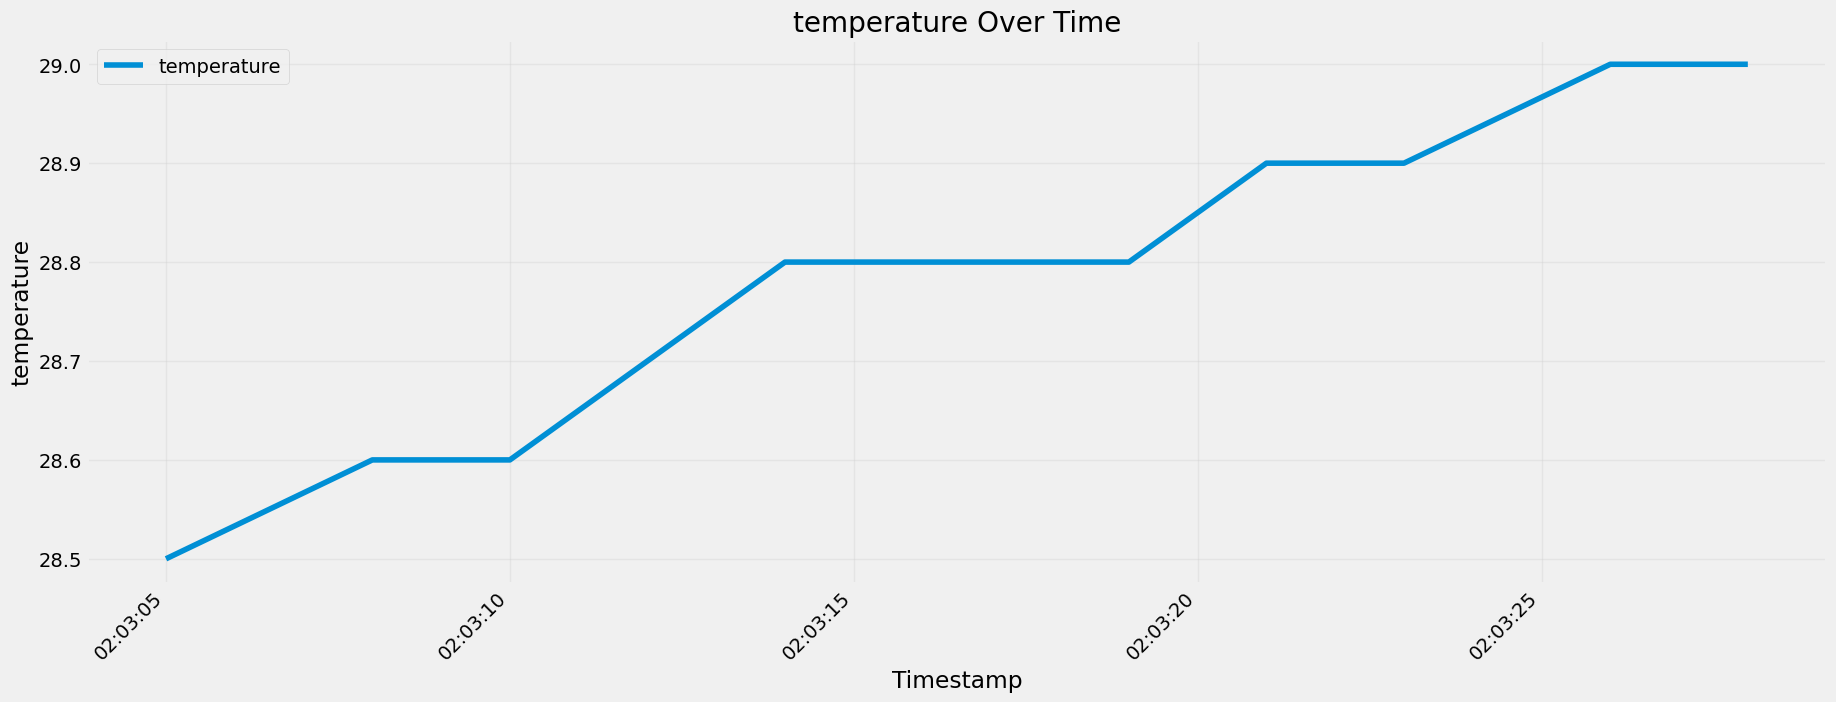

In [18]:
# Plot the prediction target over time
if 'Timestamp' in df.columns:
    df.plot(x='Timestamp', y=prediction_target, figsize=(20,8))
    plt.xticks(rotation=45)
else:
    df[prediction_target].plot(figsize=(20,8))

plt.title(f"{prediction_target} Over Time")
plt.ylabel(prediction_target)
plt.grid(True, alpha=0.3)
plt.show()

* Time series by year average

In [19]:
if 'Year' in df.columns and prediction_target in df.columns:
    df.groupby('Year')[prediction_target].mean().plot(title=f"{prediction_target} by Year")
    plt.ylabel(f"Average {prediction_target}")
    plt.show()
else:
    print("Year column not available in this dataset")

Year column not available in this dataset


* Boxplot by year

In [20]:
if 'Year' in df.columns and prediction_target in df.columns:
    df_year = df.loc[:, ['Year', prediction_target]]
    sns.boxplot(x='Year', y=prediction_target, data=df_year)
    plt.title(f"{prediction_target} Distribution by Year")
    plt.show()
else:
    print("Year column not available")

Year column not available


* Time series by month average

In [21]:
if 'Month' in df.columns and prediction_target in df.columns:
    df.groupby('Month')[prediction_target].mean().plot(title=f"{prediction_target} by Month")
    plt.ylabel(f"Average {prediction_target}")
    plt.show()
else:
    print("Month column not available")

Month column not available


* Boxplot by month

In [22]:
if 'Month' in df.columns and prediction_target in df.columns:
    df_month = df.loc[:, ['Month', prediction_target]]
    sns.boxplot(x='Month', y=prediction_target, data=df_month)
    plt.title(f"{prediction_target} Distribution by Month")
    plt.show()
else:
    print("Month column not available")

Month column not available


* Time series by day average

In [23]:
if 'Day' in df.columns and prediction_target in df.columns:
    df.groupby('Day')[prediction_target].mean().plot(title=f"{prediction_target} by Day")
    plt.ylabel(f"Average {prediction_target}")
    plt.show()
else:
    print("Day column not available")

Day column not available


* Boxplot by day

In [24]:
if 'Day' in df.columns and prediction_target in df.columns:
    df_day = df.loc[:, ['Day', prediction_target]]
    plt.figure(figsize=(10,8))
    sns.boxplot(x='Day', y=prediction_target, data=df_day)
    plt.title(f"{prediction_target} Distribution by Day")
    plt.show()
else:
    print("Day column not available")

Day column not available


* Time series by hour average

In [25]:
if 'Hour' in df.columns and prediction_target in df.columns:
    df.groupby('Hour')[prediction_target].mean().plot(title=f"{prediction_target} by Hour")
    plt.ylabel(f"Average {prediction_target}")
    plt.show()
else:
    print("Hour column not available")

Hour column not available


* Boxplot by hour

In [26]:
if 'Hour' in df.columns and prediction_target in df.columns:
    df_hour = df.loc[:, ['Hour', prediction_target]]
    plt.figure(figsize=(10,8))
    sns.boxplot(x='Hour', y=prediction_target, data=df_hour)
    plt.title(f"{prediction_target} Distribution by Hour")
    plt.show()
else:
    print("Hour column not available")

Hour column not available


# Prediction Model

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [27]:
# For sensor data, predict temperature changes
# For air quality data, use PM2.5
if 'temperature' in df.columns:
    # Sensor data - predict temperature
    df_date = pd.DataFrame(df.groupby('Timestamp')['temperature'].mean())
    df_date.columns = ['value']
    prediction_target = 'temperature'
elif 'PM2.5' in df.columns:
    # Air quality data - predict PM2.5
    df_date = pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
    df_date.columns = ['value']
    prediction_target = 'PM2.5'
else:
    # Fallback - use first numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_date = pd.DataFrame(df.groupby('Timestamp')[numeric_cols[0]].mean())
    df_date.columns = ['value']
    prediction_target = numeric_cols[0]

print(f"Predicting: {prediction_target}")
print(f"Dataset shape: {df_date.shape}")
df_date.head()

Predicting: temperature
Dataset shape: (11, 1)


,value
Timestamp,
2025-12-14 02:03:05,28.5
2025-12-14 02:03:08,28.6
2025-12-14 02:03:10,28.6
2025-12-14 02:03:12,28.7
2025-12-14 02:03:14,28.8


* Time series by each days average

<Axes: xlabel='Timestamp'>

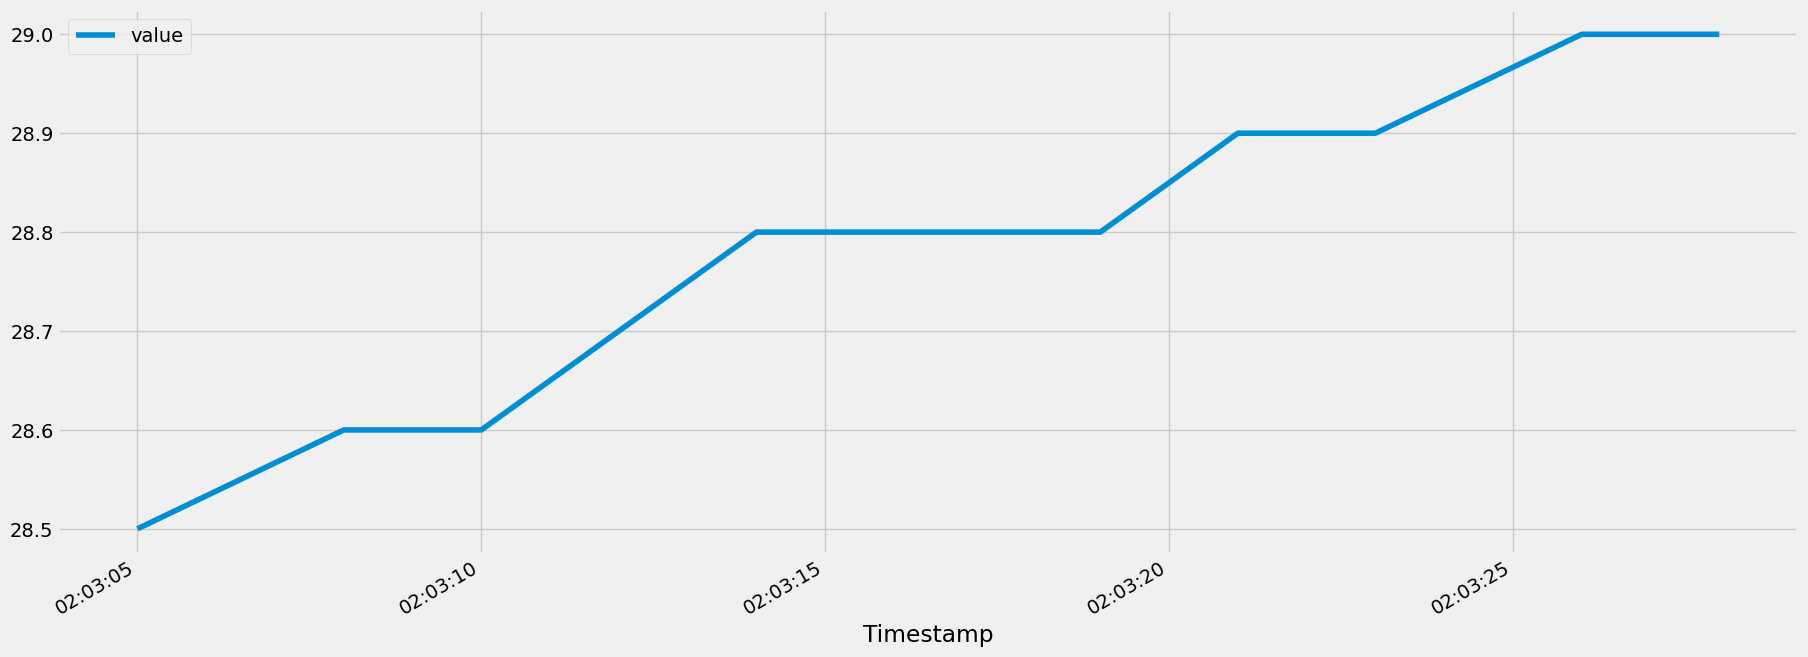

In [28]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [29]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

9

* Standardization by MinMaxScaler

In [30]:
dataset = df_date.values
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)

print(f"Dataset shape: {dataset.shape}")
print(f"Scaled data shape: {scaled_data.shape}")
print(f"Sample scaled values: {scaled_data[:5].flatten()}")

Dataset shape: (11, 1)
Scaled data shape: (11, 1)
Sample scaled values: [0.  0.2 0.2 0.4 0.6]


In [43]:
train_data = scaled_data[0:training_data_len, :]

# Dynamically adjust timestep window based on available data
# For small datasets (like sensor data with 11 samples), use fewer timesteps
num = min(60, max(3, len(train_data) // 2))  # Use 1/2 of training data or 60, whichever is smaller, but at least 3
print(f"Using timestep window: {num} (training samples: {len(train_data)})")

x_train = []
y_train = []
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

# Check if we have enough training data
if len(x_train) == 0:
    print("⚠ Warning: Not enough data to create training sequences!")
    print(f"  Training samples: {len(train_data)}, Timesteps: {num}")
    print("  Using fallback: generating synthetic augmented data...")
    
    # Generate augmented training data from available samples
    for _ in range(5):  # Create 5 augmented versions
        for i in range(num, len(train_data)):
            noise = np.random.normal(0, 0.01, num)
            x_train.append(train_data[i-num:i, 0] + noise)
            y_train.append(train_data[i, 0] + np.random.normal(0, 0.01))

print(f"✓ Created {len(x_train)} training sequences")

Using timestep window: 4 (training samples: 9)
✓ Created 5 training sequences


In [44]:
# Convert to numpy arrays with proper shape handling
x_train_list = []
y_train_list = []

for x in x_train:
    x_train_list.append(np.array(x).flatten())
for y in y_train:
    y_train_list.append(np.array(y).flatten()[0] if isinstance(y, np.ndarray) else y)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)

print(f"x_train shape before reshape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Ensure x_train is 2D
if x_train.ndim == 1:
    print("⚠ Warning: x_train is 1D, needs to be 2D for reshaping")
    x_train = x_train.reshape(-1, 1)
    print(f"After initial reshape: {x_train.shape}")

# Now reshape for LSTM (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"✓ Final x_train shape: {x_train.shape}")

x_train shape before reshape: (5, 4)
y_train shape: (5,)
✓ Final x_train shape: (5, 4, 1)


* Modeling

In [45]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [46]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [47]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3892


* Prediction

In [48]:
# Create test data using the same dynamic timestep window
test_data = scaled_data[training_data_len - num:, :]
x_test = []
y_test = []

print(f"Test data size: {len(test_data)}")
print(f"Using timestep window: {num}")

for i in range(num, len(test_data)):
    x_test.append(test_data[i-num:i, 0])
    y_test.append(test_data[i, 0])

print(f"✓ Created {len(x_test)} test sequences")
print(f"  x_test will have shape: ({len(x_test)}, {num})")
print(f"  y_test will have shape: ({len(y_test)},)")

# Convert y_test to dataset format for comparison
y_test = np.array(y_test).reshape(-1, 1)

Test data size: 6
Using timestep window: 4
✓ Created 2 test sequences
  x_test will have shape: (2, 4)
  y_test will have shape: (2,)


In [49]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [50]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


In [39]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

np.float64(27.581554412841797)

In [40]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,value,Predictions
Timestamp,,
2025-12-14 02:03:26,29.0,28.578470
2025-12-14 02:03:28,29.0,28.584639


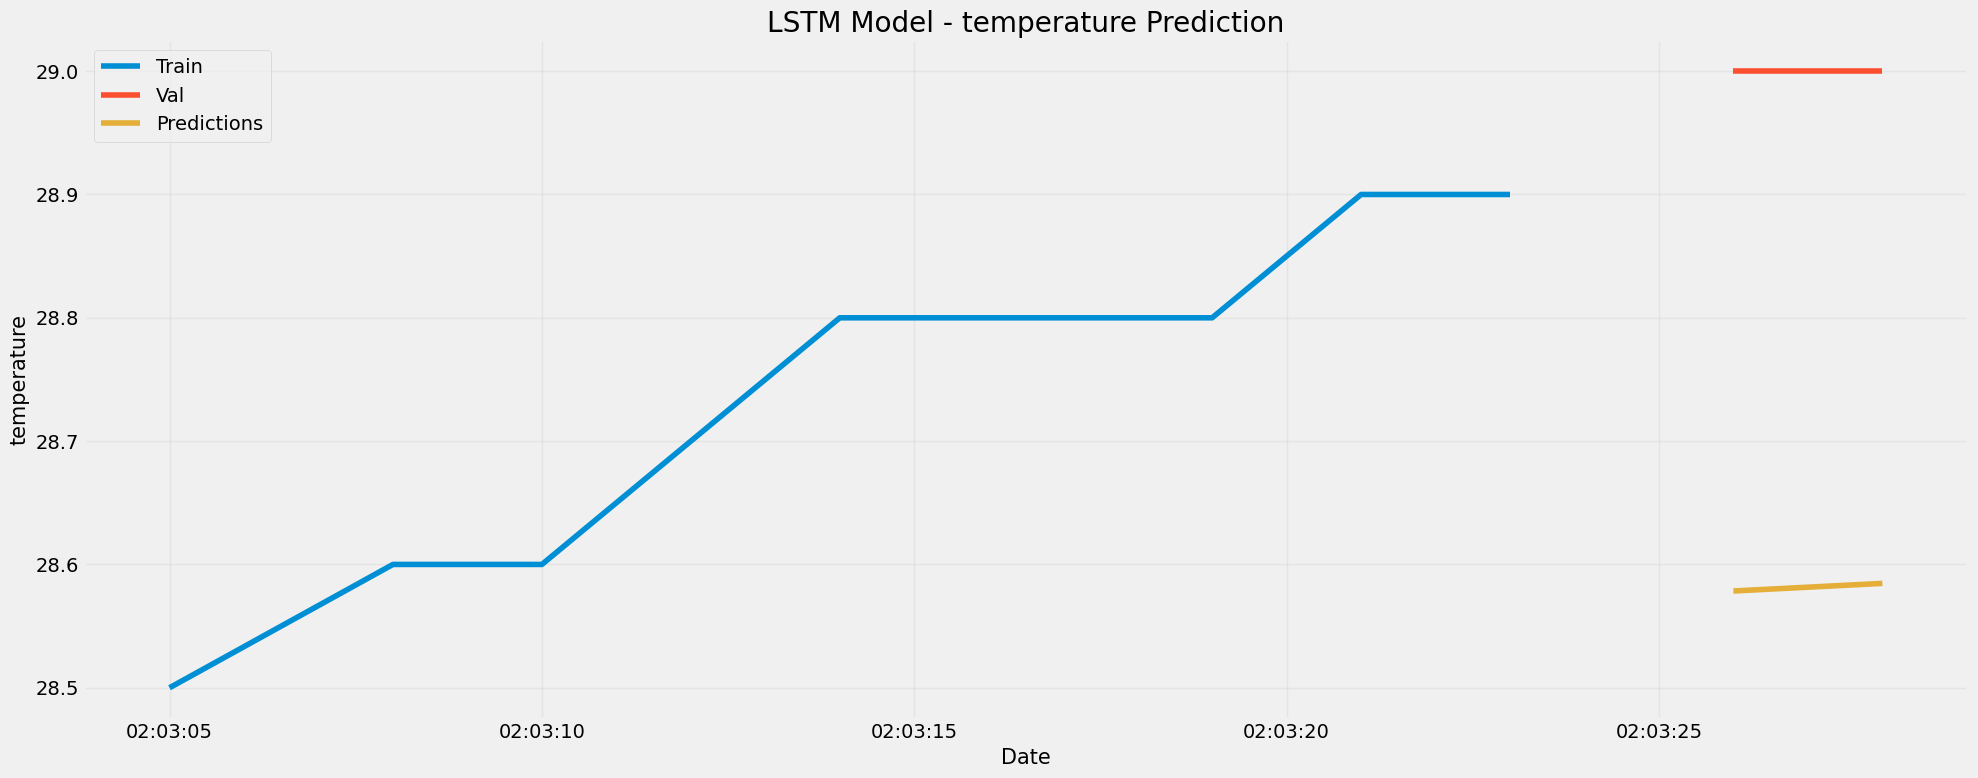

In [41]:
plt.figure(figsize=(20,8))
plt.title(f"LSTM Model - {prediction_target} Prediction")
plt.xlabel("Date", fontsize=15)
plt.ylabel(prediction_target, fontsize=15)
plt.plot(train.index, train.values, label='Training Data')
plt.plot(valid.index, valid['value'].values, label='Actual Test Data')
plt.plot(valid.index, valid["Predictions"], label='Predictions')
plt.legend(["Train", "Val", "Predictions"])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Thank you !

In [51]:
# ============================================================
# SAVE MODEL FOR PRODUCTION
# ============================================================

import os
import json

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save trained LSTM model
model.save(os.path.join(models_dir, "lstm_model.h5"))

# Save scaler for preprocessing
joblib.dump(sc, os.path.join(models_dir, "scaler_lstm.pkl"))

print("✓ LSTM Model saved successfully!")
print(f"  - lstm_model.h5")
print(f"  - scaler_lstm.pkl")

# Save metadata
metadata = {
    "model_type": "LSTM",
    "prediction_target": prediction_target,
    "input_shape": int(num),
    "rmse": float(rmse),
    "scaler_type": "MinMaxScaler",
    "training_samples": int(len(x_train)),
    "test_samples": int(len(x_test)),
    "data_source": "sensor_data.json or air-quality-india.csv"
}

with open(os.path.join(models_dir, "lstm_metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print("\nModel Metadata:")
print(f"  - Target: {prediction_target}")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - Sequence Length: {num} timesteps")
print(f"  - Training Samples: {len(x_train)}")
print(f"  - Test Samples: {len(x_test)}")

✓ LSTM Model saved successfully!
  - lstm_model.h5
  - scaler_lstm.pkl

Model Metadata:
  - Target: temperature
  - RMSE: 27.5816
  - Sequence Length: 4 timesteps
  - Training Samples: 5
  - Test Samples: 2
